Let's now see how to open up our model and do diagnostinc when model does not work/learn or to understand how the model is learning/working.
Don't try random shit!

In [1]:
import torch
import numpy as np
import random
from torch import nn,tensor
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchmetrics.classification import MulticlassAccuracy 
import fastcore.all as fc

from lib import *

In [2]:
def set_seed(seed):
    torch.use_deterministic_algorithms(True)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

@inplace
def transformi(b):
    import torchvision.transforms.functional as TF
    b[x] = [TF.to_tensor(o) for o in b[x]]

In [3]:
x,y = 'image','label'
dsd = load_dataset("fashion_mnist")
bs = 1024
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_datasetDict(tds, bs)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

In [4]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding= ks//2)
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1, 8, ks=5), # 14x14
        conv(8, 16), # 7x7
        conv(16, 32), # 4x4
        conv(32, 64), # 2x2
        conv(64, 10, act=False), #1x1
        nn.Flatten()]

def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.236,2.124,0,train
0.493,1.269,0,eval


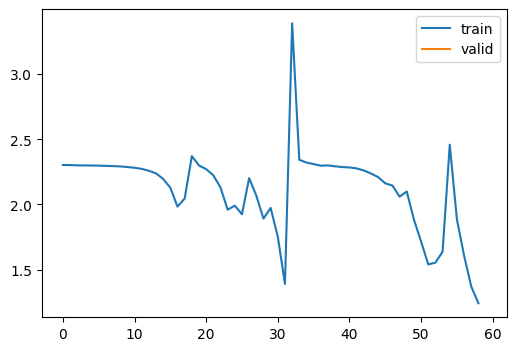

In [5]:
set_seed(1)
metrics = MetricCB(accuracy=MulticlassAccuracy(10))
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = fit(nn.Sequential(*cnn_layers()))

### - Higher lr == more general set of weights / general model
### - Higher lr == less overfitting cuz less amm of times we see batchi
### - Higher lr == more stable training (good)

It was training well but at a certain point it breaks apart. Let's try to look inside the model to understand what's going on.

# Hooks

## Manual insertion of the hook(s)

In [6]:
 class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers) # look at lect 4 for details on our own impl nn.ModuleList
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.mean().detach()) # mean of layer activations
            self.act_stds[i].append(x.std().detach()) # std of layer activations
        return x
    
    def __iter__(self): 
        return iter(self.layers)

accuracy,loss,epoch,train
0.236,2.124,0,train
0.493,1.269,0,eval


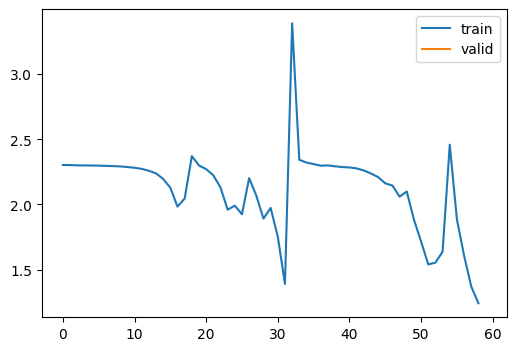

In [7]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

So now let's plot these means/stds:

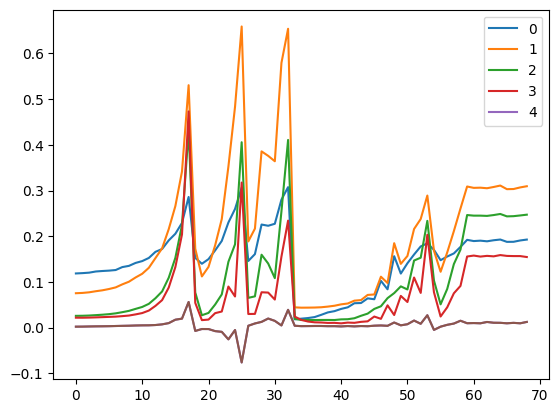

In [8]:
for layer_activations_mean in model.act_means: plt.plot(layer_activations_mean)
plt.legend(range(5))

When activations are close to 0 -> the model is not training! Neurons not firing -> no decision process

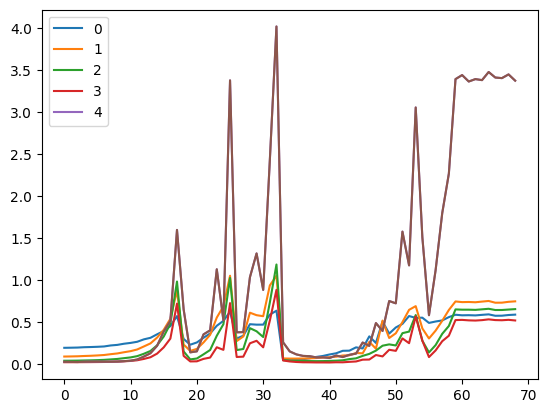

In [9]:
for layer_activations_stds in model.act_stds: plt.plot(layer_activations_stds)
plt.legend(range(5))

Actually what you want is average of activations close to 0 but spread around
so they have to have a variance close to 1.
In the cases abve after batch 30 activations goto 0 stds goto 0 -> dead nn
The shape that starts from 0, increases and then drops and then increases again further then previous peak is a classic "bad behavior" pattern.

It's important to always check these plots in your model!

Now let's look at how to save act_means and act_stds in a nicer way using 
pytorch hooks.

# Pytorch hooks (hooks are just callbacks)

Hooks are pytorch objects that you can add to any nn.Module. A hook will be called when a layer, if it is registered to it, is executed during the forward pass (forward hook) or the backward pass (backward hook). Hooks don't require us to rewrite the model, you can add them to any existing nn.Module. Let's try to recreate act_means and act_stds as above:

## Important:
A hook is attached to a layer and it needs/executes a function that __MUST__ takes 3 args: a module, an input and an output.

In [10]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [11]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

def append_stats(i, mod, inp, out): # v0, dependent on external containers
    act_means[i].append(out.mean().detach())
    act_stds[i].append(out.std().detach())

The hook will call append_stats() during the forward pass of the model.
register_backward_hook for hooks to be triggered at backward pass of the layer

In [12]:
for i, layer in enumerate(model):
    layer.register_forward_hook(partial(append_stats, i)) 
    
# during forward pass after each layer it is executed partial(append_stats, i)
# i is the first argument, partial takes positional arguments

accuracy,loss,epoch,train
0.236,2.124,0,train
0.493,1.269,0,eval


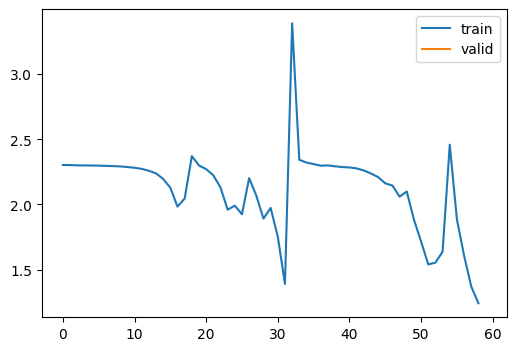

In [13]:
fit(model)

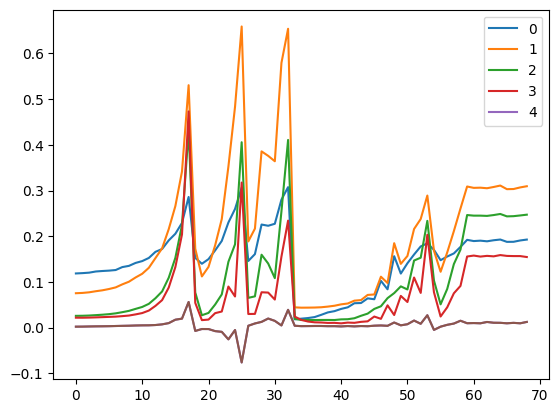

In [14]:
for l in act_means: plt.plot(l)
plt.legend(range(5))

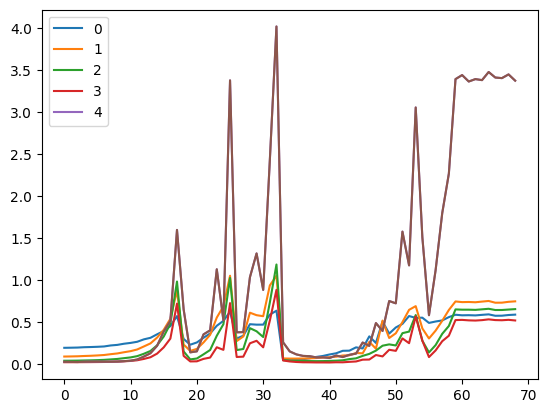

In [15]:
for l in act_stds: plt.plot(l)
plt.legend(range(5))

Now let's start working towards an hook class that does not depends on globals (eg act_means, act_stds lists above)

In [16]:
class Hook(): 
    '''single hook for a single layer: n layers -> n Hook'''
    def __init__(self, layer, func): # layer or module
        '''
        Given a nn.Module (i.e., a layer), handles the hook registered onto it.
        func: the func to be called at forward pass
        '''
        self.hook = layer.register_forward_hook(partial(func, self))
        
    def remove(self):
        self.hook.remove() # removes hook from layer
        
    def __del__(self):
        self.remove()

In [17]:
def append_stats(hook, module, inp, output): # v1, creates the container inside each Hook obj       
    ''' Grabs activations and computes their mean and their std'''
    if not hasattr(hook,'stats'): 
        hook.stats = ([],[])
    activations = output.detach()
    hook.stats[0].append(activations.mean())
    hook.stats[1].append(activations.std())

In [18]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [19]:
# for each layer create an hook 
hooks = [Hook(l, append_stats) for l in model[:5].children()] # just omits Flatten(start_dim=1, end_dim=-1)

accuracy,loss,epoch,train
0.236,2.124,0,train
0.493,1.269,0,eval


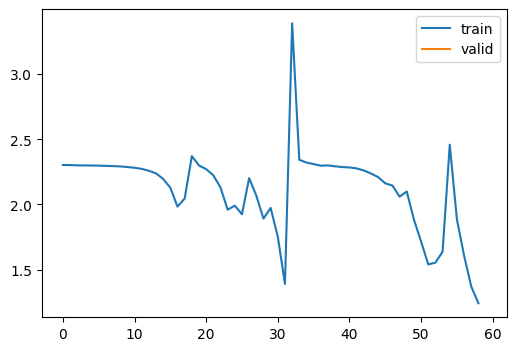

In [20]:
learn = fit(model)

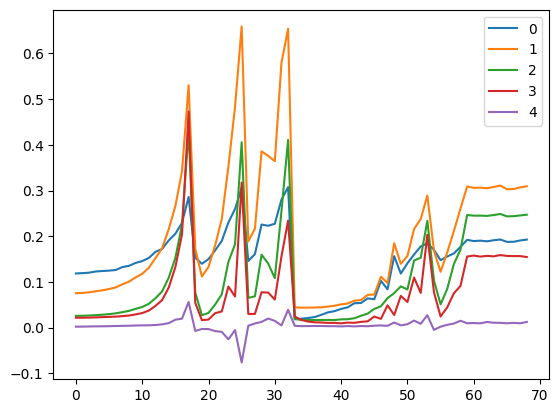

In [21]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5))

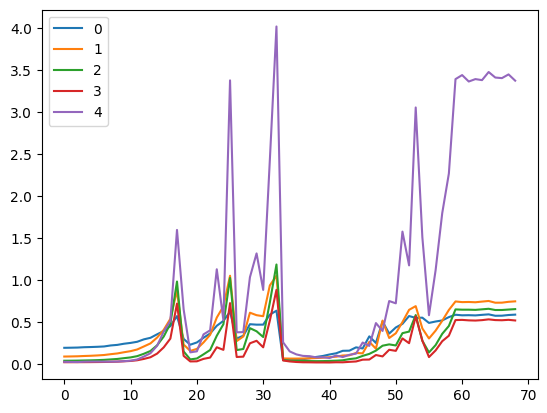

In [22]:
for h in hooks:
    plt.plot(h.stats[1])
    h.remove()
plt.legend(range(5))

Let's keep improving the design of the code

In [23]:
class Hooks(list): 
    """
    Inherit from list, iterable
    Container of Hook objects.    
    By defining __enter__ and __exit__ this class can be used as a context manager:
        - __enter__() defines code to be executed before when entering into the contex manager; 
            if you use with Hooks(...) as hooks <- hooks will contain the return of the __enter__ call 
        - __exit__() defines code to be executed before when exiting the contex manager
    """
    
    def __init__(self, func, modules):
        '''
        Register Hook objs for each layer
        '''
        super().__init__([Hook(module, func) for module in modules]) # modules or layers
        
    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args):
        self.remove()
        
    def __del__(self):
        self.remove()
        
    def __delitem__(self, i):
        # removes single hook, optional
        self[i].remove()
        super.__delitem__(i)
        
    def remove(self):
        for h in self: # self is list
            h.remove()

accuracy,loss,epoch,train
0.236,2.124,0,train
0.493,1.269,0,eval


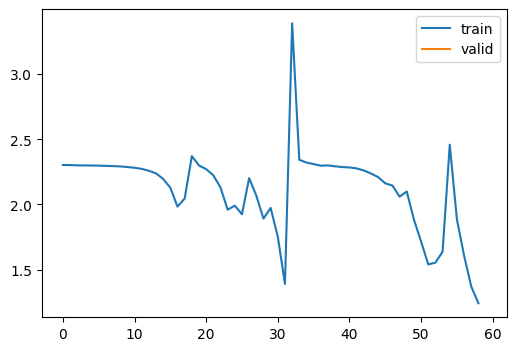

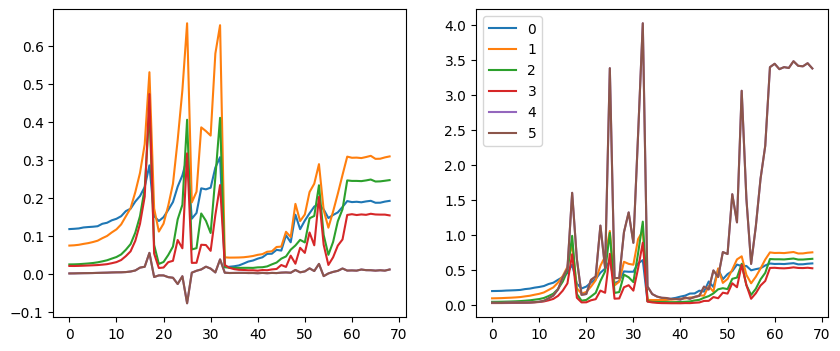

In [24]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

with Hooks(append_stats, model) as hooks:
    fit(model)
    fig, axs = plt.subplots(1,2, figsize=(10, 4))
    for h in hooks: # since iterable
        for i in 0,1:
            axs[i].plot(h.stats[i])
    plt.legend(range(6))    

# HooksCallback
Let's now create a callback that can be added to the learner that automatically saves activations statistics

In [25]:
class HooksCallback(Callback):
    def __init__(self, hookfunc, module_filter=fc.noop, on_train=True, on_valid=False, modules=None):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn):
        ''' Create Hook objs for each layer in modules'''
        if self.modules: 
            modules=self.modules # only input modules
        else: 
            modules = fc.filter_ex(learn.model.modules(), self.module_filter)
        self.hooks = Hooks(partial(self._hookfunc, learn), modules)

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): # granular control on when to activate 
            self.hookfunc(*args, **kwargs) # function to be applied by each hook

    def after_fit(self, learn): 
        self.hooks.remove() # remove all Hooks
    
    # Since Hooks is a list we can use:
    def __iter__(self): 
        return iter(self.hooks)
    
    def __len__(self): 
        return len(self.hooks)

In [26]:
# fc.noop? #  Docstring: Do nothing, function

accuracy,loss,epoch,train
0.236,2.124,0,train
0.493,1.269,0,eval


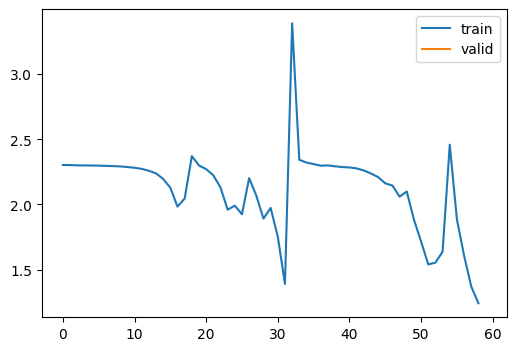

In [27]:
hc = HooksCallback(append_stats, module_filter=fc.risinstance(nn.Conv2d))
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc]);

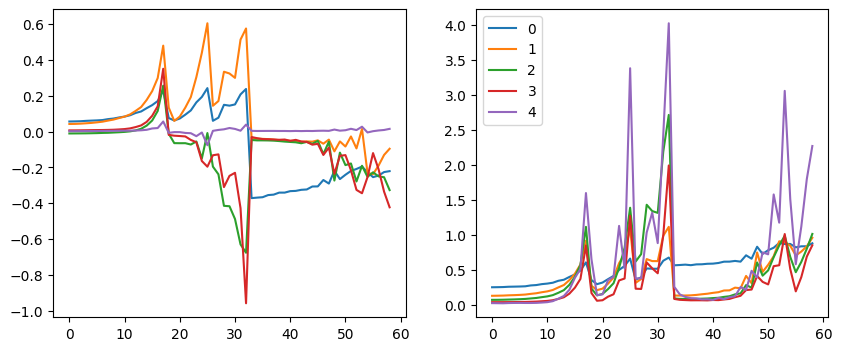

In [28]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6));

# Histogram of  activations:

In [29]:
def append_stats(hook, mod, inp, outp): # v2, creates the container inside each Hook obj, added hist stats 
    if not hasattr(hook,'stats'): 
        hook.stats = ([],[],[])
    acts = outp.detach()
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10)) # adds hist of abs vals of activations, 50 bins 

Compute hist

accuracy,loss,epoch,train
0.236,2.124,0,train
0.493,1.269,0,eval


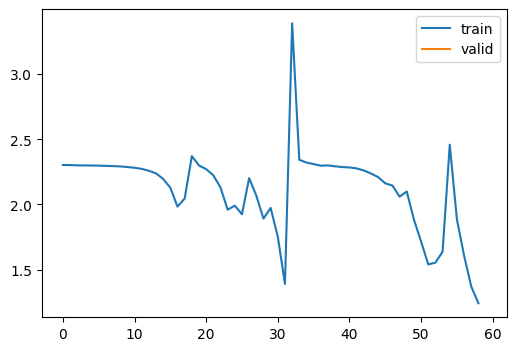

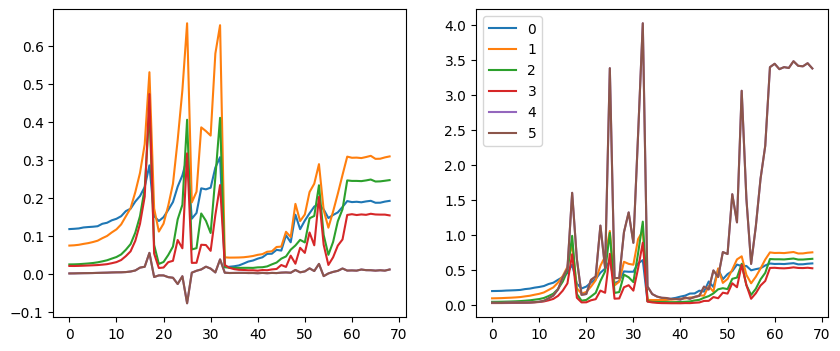

In [30]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

with Hooks(append_stats, model) as hooks:
    fit(model)
    fig, axs = plt.subplots(1,2, figsize=(10, 4))
    for h in hooks:
        for i in 0,1:
            axs[i].plot(h.stats[i])
    plt.legend(range(6))
    

In [31]:
def get_hist(h): 
    return torch.stack(h.stats[2]).t().float().log1p() # with log you can see the range more clearly

@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

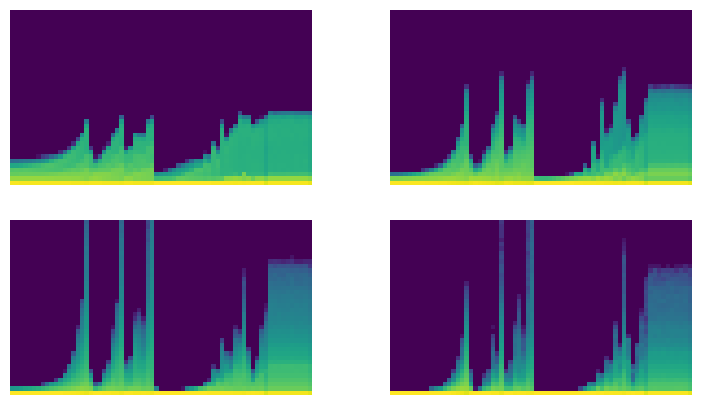

In [32]:
fig, axes = plt.subplots(2,2, figsize=(9,5))
for ax, h in zip(axes.flatten(), hooks[:4]):
    show_image(get_hist(h), ax, origin="lower")

Now we plot the abs values of the activations as histogram
Same pattern as b4 of peak-crash sequence.

each col of the picture is an hist by itself: each col of pixel is the mapping of 1 hist into color-mapping wrt counts.
It represents the distirbution by color of the activations at each step/batch

The yellow line at the bottom of the pictures show/describe how the majority of the activations are very close to 0.

Desired shape -> a rectangle with a smooth gradient color in each col, max not flickering so much and not such a well 
defined yellow bar at the bottom -> normal dist over the colors.

Another tool to describe this situation is: 

In [33]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

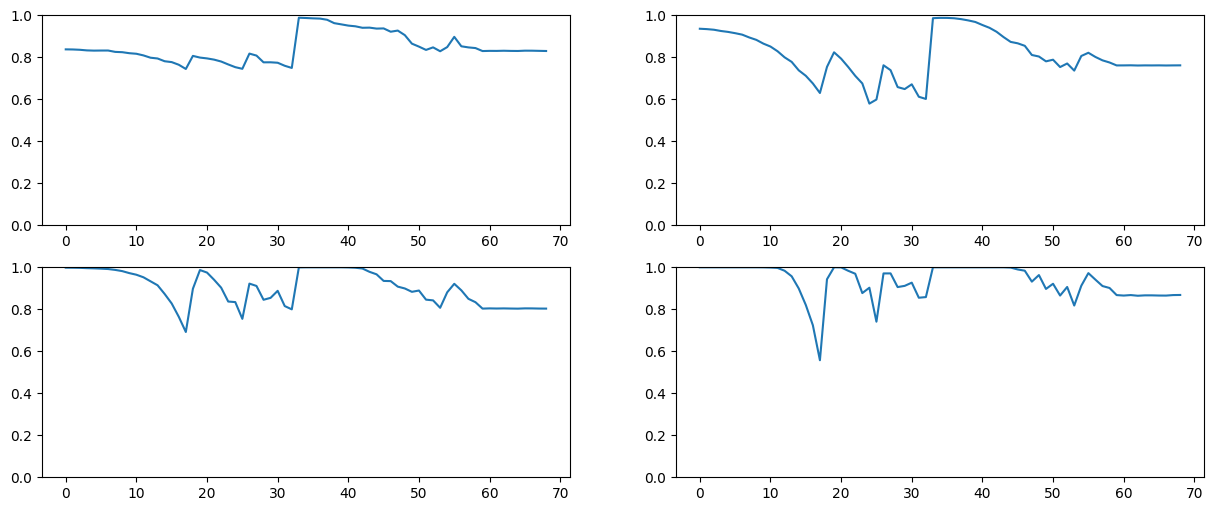

In [34]:
fig, axes = plt.subplots(2,2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)

Compare the % of: first 2 rows of pixels (that contain near 0 vals) wrt total number of pixels.
If the plots here above are close to 1 it means that almost all activations are near 0.
If all activations close to 0 -> model not working. Even if the end there is a rectangle but early start/crash pattern -> failure mode -> restart training!

In [63]:
from fastai.vision.all import get_grid

class ActivationStats(HooksCallback):
    '''
    Behaves exactly as HooksCallback.
    Additional plot features.
    '''
    
    def __init__(self, hookfunc, module_filter=fc.noop): 
        ''' module_filter get only acts of the module type assed as input'''
        super().__init__(hookfunc=hookfunc, module_filter=module_filter)

    def color_dim(self, figsize=(11,5)):
        fig, axes = plt.subplots(2,3, figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig, axes = plt.subplots(2,3, figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))
        
    def plot_all(self):
        self.color_dim()
        self.dead_chart()
        self.plot_stats()                        

In [64]:
astats = ActivationStats(append_stats, fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.236,2.124,0,train
0.493,1.269,0,eval


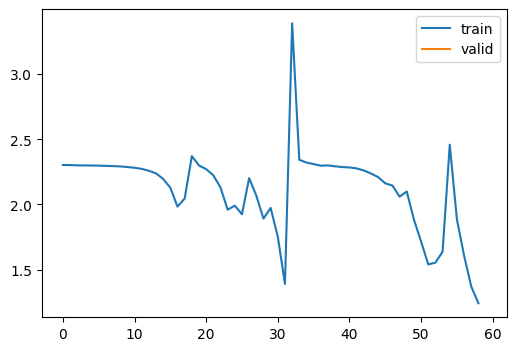

In [65]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

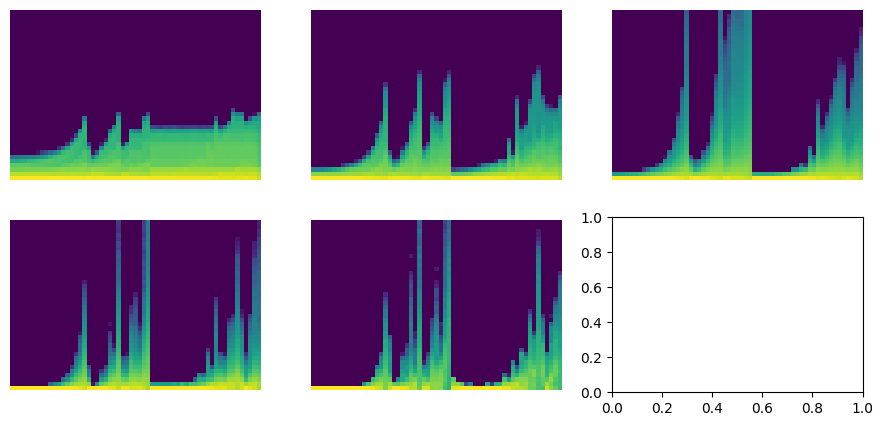

In [66]:
astats.color_dim()

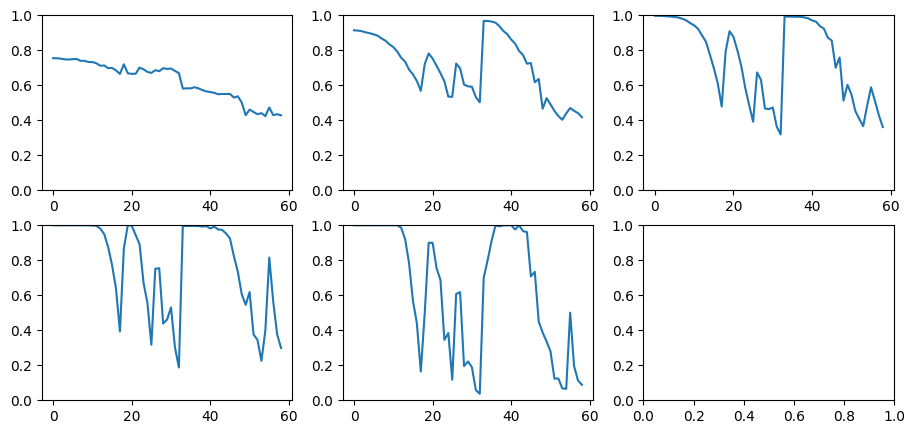

In [67]:
astats.dead_chart()

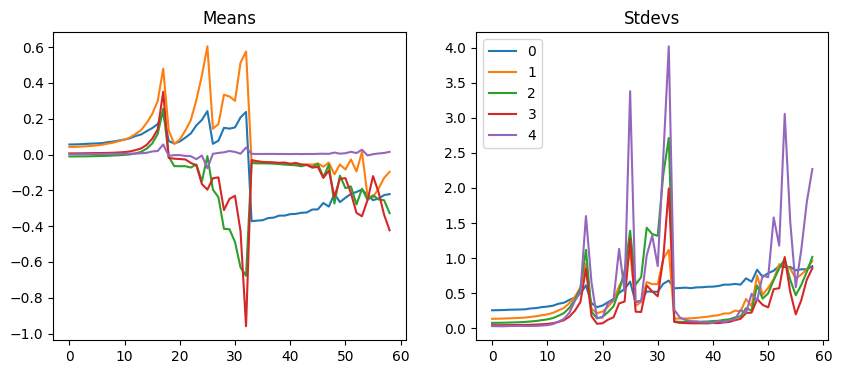

In [68]:
astats.plot_stats()